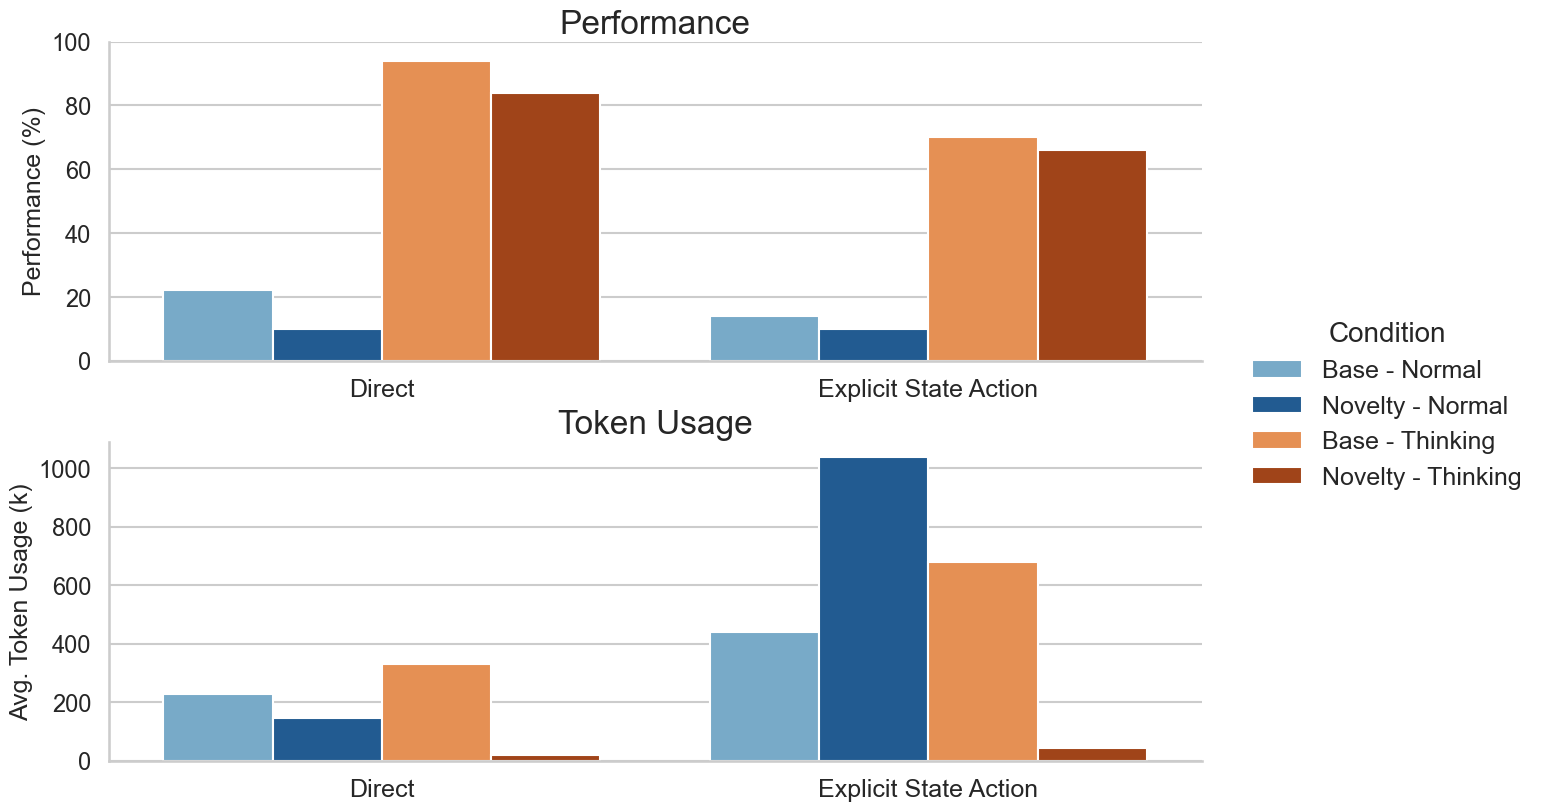

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.reset_defaults()

# Data
methods = ["Direct", "Explicit State Action"]

# Raw counts (successes out of trials) and token usage (in thousands)
trials = 50
raw_perf = {
    "Base": {"Normal": np.array([11, 7]), "Thinking": np.array([47, 35])},
    "Novelty": {"Normal": np.array([5, 5]),  "Thinking": np.array([42, 33])},
}

tokens_k = {
    "Base": {"Normal": np.array([229, 438]), "Thinking": np.array([330, 680])},
    "Novelty": {"Normal": np.array([146, 1038]), "Thinking": np.array([18, 43])},
}

# Convert performance counts to percentages
perf_base_normal = raw_perf["Base"]["Normal"] / trials * 100
perf_novelty_normal = raw_perf["Novelty"]["Normal"] / trials * 100
perf_base_thinking = raw_perf["Base"]["Thinking"] / trials * 100
perf_novelty_thinking = raw_perf["Novelty"]["Thinking"] / trials * 100

# Token arrays (already in thousands)
tokens_base_normal = tokens_k["Base"]["Normal"]
tokens_novelty_normal = tokens_k["Novelty"]["Normal"]
tokens_base_thinking = tokens_k["Base"]["Thinking"]
tokens_novelty_thinking = tokens_k["Novelty"]["Thinking"]

# Build tidy DataFrames for seaborn
hue_order = ["Base - Normal", "Novelty - Normal", "Base - Thinking", "Novelty - Thinking"]

def make_df(values_per_hue):
    rows = []
    for label, arr in values_per_hue.items():
        for i, m in enumerate(methods):
            rows.append({"Method": m, "Setting": label, "Value": float(arr[i])})
    return pd.DataFrame(rows)

perf_df = make_df({
    "Base - Normal": perf_base_normal,
    "Novelty - Normal": perf_novelty_normal,
    "Base - Thinking": perf_base_thinking,
    "Novelty - Thinking": perf_novelty_thinking,
})

tokens_df = make_df({
    "Base - Normal": tokens_base_normal,
    "Novelty - Normal": tokens_novelty_normal,
    "Base - Thinking": tokens_base_thinking,
    "Novelty - Thinking": tokens_novelty_thinking,
})

# Seaborn aesthetics
# Increase font sizes globally: raise seaborn font_scale and set matplotlib rcParams
sns.set_theme(style="whitegrid", context="talk", font_scale=1)
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 24,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 17,
    'legend.fontsize': 18,
    'legend.title_fontsize': 20,
    'figure.titlesize': 14,
})

# Two color families: Normal = Blues, Thinking = Oranges
normal_palette = sns.color_palette("Blues", n_colors=5)
thinking_palette = sns.color_palette("Oranges", n_colors=5)

# Lighter tone for Base, darker for Novelty (swap indices if you want the opposite)
palette_map = {
    "Base - Normal": normal_palette[2],
    "Novelty - Normal": normal_palette[4],
    "Base - Thinking": thinking_palette[2],
    "Novelty - Thinking": thinking_palette[4],
}

# Stack plots vertically: 2 rows, 1 column; increase width to make graphs wider
fig, axs = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

# Performance plot
sns.barplot(
    data=perf_df, x="Method", y="Value", hue="Setting",
    hue_order=hue_order, palette=palette_map, ax=axs[0],
)
axs[0].set_ylabel("Performance (%)")
axs[0].set_xlabel("")
axs[0].set_title("Performance")
axs[0].set_ylim(0, 100)

# Token usage plot
sns.barplot(
    data=tokens_df, x="Method", y="Value", hue="Setting",
    hue_order=hue_order, palette=palette_map, ax=axs[1],
)
axs[1].set_ylabel("Avg. Token Usage (k)")
axs[1].set_xlabel("")
axs[1].set_title("Token Usage")

# Build one shared legend for both plots (grab from first axes)
handles, labels = axs[0].get_legend_handles_labels()

# Enforce the desired hue order if present
label_to_handle = dict(zip(labels, handles))
handles = [label_to_handle[lbl] for lbl in hue_order if lbl in label_to_handle]
labels = [lbl for lbl in hue_order if lbl in label_to_handle]

# Remove per-axes legends
for ax in axs:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Add figure-level legend to the right side as a vertical legend
fig.legend(
    handles, labels, title="Condition",
    loc="center left", ncol=1, frameon=False,
    bbox_to_anchor=(1.02, 0.5),
)

sns.despine()

# save as SVG
fig.savefig("tot_comparison.svg", bbox_inches="tight")

plt.show()

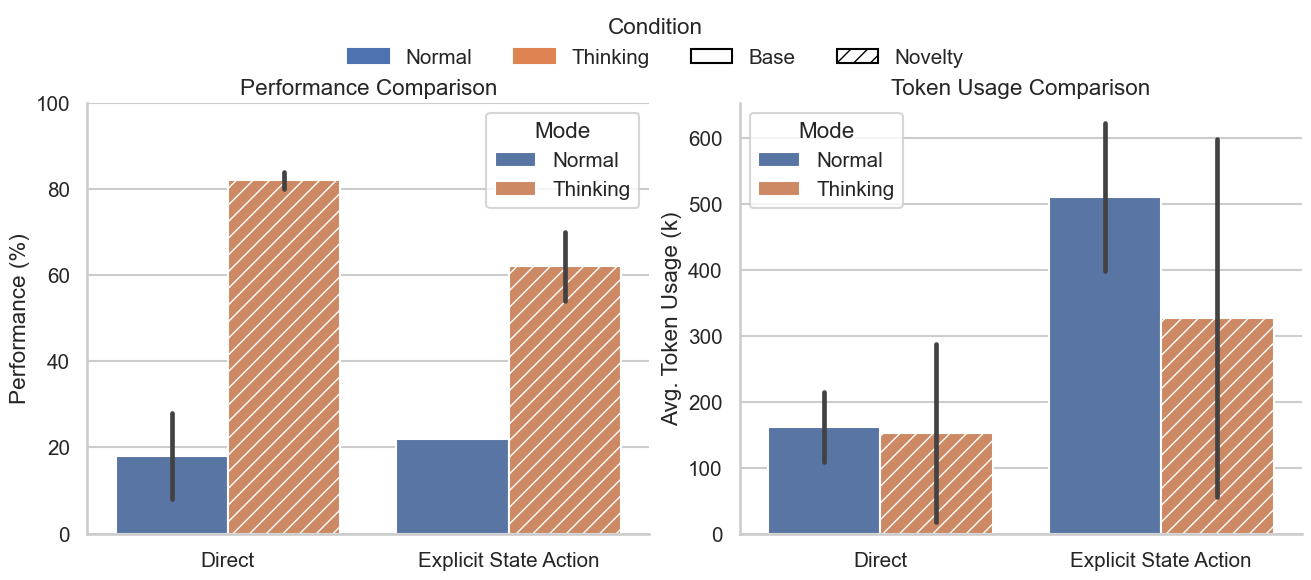

In [5]:
import matplotlib.patches as mpatches

# Separate variables for style
perf_df["Mode"] = perf_df["Setting"].apply(lambda s: "Normal" if "Normal" in s else "Thinking")
perf_df["Domain"] = perf_df["Setting"].apply(lambda s: "Base" if "Base" in s else "Novelty")

tokens_df["Mode"] = tokens_df["Setting"].apply(lambda s: "Normal" if "Normal" in s else "Thinking")
tokens_df["Domain"] = tokens_df["Setting"].apply(lambda s: "Base" if "Base" in s else "Novelty")

# Define consistent palettes
mode_palette = {"Normal": "#4c72b0", "Thinking": "#dd8452"}   # 2 distinct colors
hatches = {"Base": "", "Novelty": "//"}                       # no hatch vs. hatched

fig, axs = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

# --- Plot helper ---
def plot_bars(df, ax, ylabel, title):
    bars = sns.barplot(
        data=df, x="Method", y="Value",
        hue="Mode", palette=mode_palette, ax=ax, dodge=True
    )
    # Apply hatches based on "Domain"
    for patch, (_, row) in zip(bars.patches, df.iterrows()):
        hatch = hatches[row["Domain"]]
        patch.set_hatch(hatch)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.set_title(title)
    return bars

# Performance plot
plot_bars(perf_df, axs[0], "Performance (%)", "Performance Comparison")
axs[0].set_ylim(0, 100)

# Token usage plot
plot_bars(tokens_df, axs[1], "Avg. Token Usage (k)", "Token Usage Comparison")

# --- Custom legend ---
mode_patches = [mpatches.Patch(color=col, label=lab) for lab, col in mode_palette.items()]
domain_patches = [mpatches.Patch(facecolor="white", hatch=hatches[lab],
                                 edgecolor="black", label=lab) for lab in hatches]

fig.legend(
    handles=mode_patches + domain_patches,
    title="Condition",
    loc="upper center", ncol=4, frameon=False,
    bbox_to_anchor=(0.5, 1.15)
)

sns.despine()
plt.show()


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rows = []
for domain in ["Base", "Novelty"]:
    for mode in ["Normal", "Thinking"]:
        perf_arr = raw_perf[domain][mode]
        tok_arr = tokens_k[domain][mode]
        for i, method in enumerate(methods):
            successes = float(perf_arr[i])
            perf_pct = successes / trials * 100.0
            tok_k = float(tok_arr[i])
            rows.append({
                "Method": method,
                "Domain": domain,
                "Mode": mode,
                "Setting": f"{domain} - {mode}",
                "Performance": perf_pct,
                "Tokens_k": tok_k,
                "Successes": successes,
            })

df = pd.DataFrame(rows)
df

,Method,Domain,Mode,Setting,Performance,Tokens_k,Successes
0,Direct,Base,Normal,Base - Normal,28.0,215.0,14.0
1,Explicit State Action,Base,Normal,Base - Normal,22.0,398.0,11.0
2,Direct,Base,Thinking,Base - Thinking,84.0,288.0,42.0
3,Explicit State Action,Base,Thinking,Base - Thinking,70.0,598.0,35.0
4,Direct,Novelty,Normal,Novelty - Normal,8.0,109.0,4.0
5,Explicit State Action,Novelty,Normal,Novelty - Normal,22.0,622.0,11.0
6,Direct,Novelty,Thinking,Novelty - Thinking,80.0,18.0,40.0
7,Explicit State Action,Novelty,Thinking,Novelty - Thinking,54.0,56.0,27.0


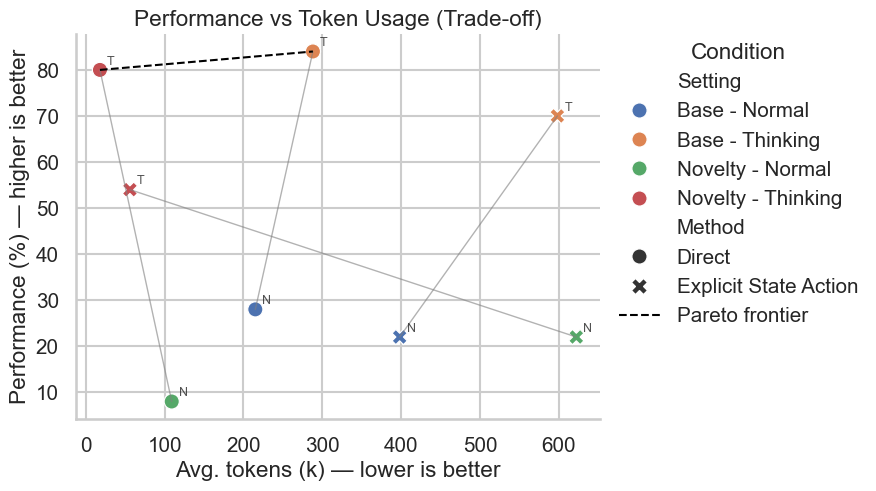

In [12]:
# 1) Trade-off scatter: performance vs tokens, with Normal↔Thinking connections and Pareto frontier
sns.set_theme(style="whitegrid", context="talk", font_scale=0.9)

fig, ax = plt.subplots(figsize=(8, 5))  # widened to make room for side legend
scatter = sns.scatterplot(
    data=df,
    x="Tokens_k", y="Performance",
    hue="Setting", style="Method", s=120, ax=ax
)

# Connect Normal -> Thinking within each (Domain, Method) pair
for (dom, meth), sub in df.groupby(["Domain", "Method"]):
    sub2 = sub.set_index("Mode").loc[["Normal", "Thinking"]].reset_index()
    ax.plot(sub2["Tokens_k"], sub2["Performance"], color="gray", alpha=0.6, linewidth=1)

# Label points with N/T for quick reading
for _, r in df.iterrows():
    ax.annotate(r["Mode"][0], (r["Tokens_k"], r["Performance"]),
                textcoords="offset points", xytext=(5, 4), fontsize=9, alpha=0.8)

# Pareto frontier (maximize Performance, minimize Tokens_k)
pts = df[["Tokens_k", "Performance"]].to_numpy()
is_eff = np.ones(len(pts), dtype=bool)
for i, (x_i, y_i) in enumerate(pts):
    dominated = ((df["Tokens_k"] <= x_i) & (df["Performance"] >= y_i) &
                 ((df["Tokens_k"] < x_i) | (df["Performance"] > y_i)))
    if np.any(dominated.drop(index=i)):
        is_eff[i] = False
pareto_df = df[is_eff].sort_values("Tokens_k")
ax.plot(pareto_df["Tokens_k"], pareto_df["Performance"],
        linestyle="--", color="black", linewidth=1.5, label="Pareto frontier")

ax.set_xlabel("Avg. tokens (k) — lower is better")
ax.set_ylabel("Performance (%) — higher is better")
ax.set_title("Performance vs Token Usage (Trade-off)")

# Move legend to the right, outside the axes
ax.legend(title="Condition", loc="upper left",
          bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=False)

sns.despine()

# Make room on the right for the outside legend
fig.subplots_adjust(right=0.78)

plt.show()

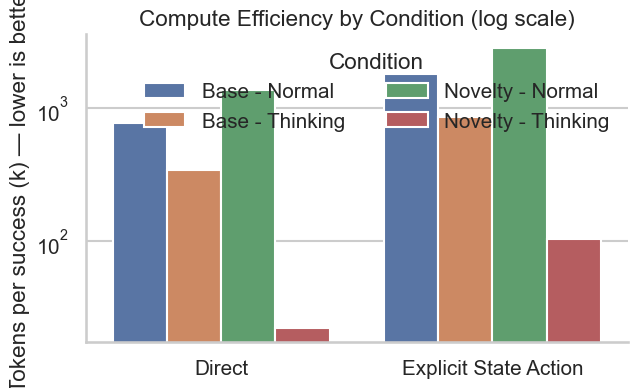

In [11]:
# 2) Compute-efficiency bar: tokens per success (k), lower is better (log scale)
eff_df = df.copy()
eff_df["Tokens_per_success_k"] = eff_df["Tokens_k"] / (eff_df["Performance"] / 100.0)

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    data=eff_df, x="Method", y="Tokens_per_success_k",
    hue="Setting", ax=ax
)
ax.set_yscale("log")
ax.set_ylabel("Tokens per success (k) — lower is better")
ax.set_xlabel("")
ax.set_title("Compute Efficiency by Condition (log scale)")
ax.legend(ncol=2, frameon=False, title="Condition")
sns.despine()
plt.show()